In [784]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.circuit.library.standard_gates import RZGate, RYGate, PhaseGate
from qiskit.quantum_info import Statevector, Operator

import itertools
import numpy as np
import math

# Computing Quantum State Angles
While we are given the coefficients of our quantum state $\psi = \sum_{x=0}^{2^n-1} \psi_x |x\rangle_n$, we need to determine what angles $\{\theta_{i}^k : 0\leq i < 2^k, 0\leq k < n\}$ we need to rotate our qubits by given $\{\psi_x\}$. We assume for now that each $\psi_x$ is real-valued, and will deal with the phase separately. This is entirely an exercise in trigonometry and algebra, and consequently, we don't need to introduce any of the quantum circuits yet.

For clarity, we demonstrate how we generate the coefficients in the case of $n=3$. We observe that, for some choice of parameters $\{\theta_{i}^k\}$, we have
\begin{align*}
\psi = &\left(\cos(\theta^2_0/2)|0\rangle +\sin(\theta^2_0/2)|1\rangle\right)\cos(\theta_0^1/2)|0\rangle\cos(\theta_{0}^{0}/2)|0\rangle\\
+&\left(\cos(\theta^2_1/2)|0\rangle +\sin(\theta^2_1/2)|1\rangle\right)\sin(\theta_{0}^{1}/2)|1\rangle\cos(\theta_0^0/2)|0\rangle\\
+&\left(\cos(\theta^2_2/2)|0\rangle +\sin(\theta^2_2/2)|1\rangle\right)\cos(\theta_{1}^{1}/2)|0\rangle\sin(\theta_0^0/2)|1\rangle\\
+&\left(\cos(\theta^2_3/2)|0\rangle +\sin(\theta^2_3/2)|1\rangle\right)\sin(\theta_1^1/2)|1\rangle\sin(\theta_{0}^{0}/2)|1\rangle\\
\end{align*}

Using this, we see that $\psi_0 = \cos(\theta_0^2/2)\cos(\theta_0^1/2)\cos(\theta_0^0/2)$, $\psi_1 = \sin(\theta_0^2/2)\cos(\theta_0^1/2)\cos(\theta_0^0/2)$, and so on. Thus, $$\cos(\theta_0^0/2)^2 = \psi_0^2 + \psi_1^2 + \psi_2^2 + \psi_3^2.$$ Meanwhile, to solve for $\theta_0^1$, with the knowledge of $\theta_0^0$ in hand, all we need to do is observe that
$$\cos(\theta_0^1/2)^2 = \frac{\psi_0^2 + \psi_1^2}{\cos(\theta_0^0/2)^2} = \frac{\psi_0^2 + \psi_1^2}{\psi_0^2 + \psi_1^2 + \psi_2^2 + \psi_3^2}.$$
Finally,
$$\cos(\theta_0^2/2) = \frac{\psi_0}{\cos(\theta_0^1/2)\cos(\theta_0^0/2)} = \frac{\psi_0}{\sqrt{\psi_0^2+ \psi_1^2}}.$$
The computation of the rest of the coefficients is done in a similar manner, so we only record the results here.

\begin{align*}
\cos(\theta_1^2/2) &= \frac{\psi_2}{\sqrt{\psi_2^2+ \psi_3^2}}\\
\cos(\theta_1^1/2) &= \sqrt{\frac{\psi_4^2 + \psi_5^2}{\psi_4^2 + \psi_5^2 + \psi_6^2 + \psi_7^2}}\\
\cos(\theta_2^2/2) &= \frac{\psi_4}{\sqrt{\psi_4^2+\psi_5^2}}\\
\cos(\theta_3^2/2) &= \frac{\psi_6}{\sqrt{\psi_6^2+\psi_7^2}}
\end{align*}

Below, we establish a function to do this for general values of $n$.

In [458]:
def angle_generator_array(coefficients:list):
    #First we need to ensure that our list has 2^n elements for some integer n.
    n = np.log2(len(coefficients))
    assert n == int(n), "There need to be 2^n coefficients for some positive integer n"
    # Now we make sure that each of the list elements is actually a real number
    assert all(item == float(item) for item in coefficients), "Make sure that each of the list elements is a real number"
    #Finally we check that the norm of the coefficients is 1
    assert np.round(np.sqrt(sum(np.array(coefficients)**2)),3) ==1, "This needs to be a norm one list of coefficients"
    #We can now generate our angles based on these coefficients. For ease of computation, we will transform our list into squares
    n = int(n)
    sq_coefficients = list(map(lambda x: x**2,coefficients))
    #We treat our first angle separately, as we don't need to consider the case where our starting qubit is |1>
    angle_array = np.zeros([n,2**(n-1)])
    angle_array[0] = angle_array[0]+2*np.arccos(np.sqrt(sum(sq_coefficients[0:2**(n-1)])))
    #We will need to break our list of coefficients down into every consecutive group of size 2^m for some m < n
    for i in range(1,n):
        batched_coefficients = itertools.batched(sq_coefficients,2**(n-i))
        angles = np.array([])
        for group in batched_coefficients:
            angles = np.append(angles,2*np.arccos(np.sqrt(sum(group[0:2**(n-i-1)])/sum(group))))
        angle_array[i] = np.repeat(angles,2**(n-(i+1)))
    return angle_array

# Dealing with Phases
Given $\psi = \sum_{x=0}^{2^n-1} \psi_x |x\rangle_n$, we are not guaranteed that every $\psi_x$ is real-valued. Instead, we may have $\psi_x\in\mathbb{C}$. In this case, we will record the phases separately, writing $\psi_x = e^{i\phi(x)}|\psi_x|$, where $\phi(x)$ is the phase, and $|\psi_x|$ is the magnitude. Below we give a function which takes in a list of $2^n$ complex numbers (written in tuple form $(a,b) \leftrightarrow a + bi$), and returns a list of magnitudes and a list of phases. We then create a circuit which takes an arbitrary state, and transforms every qubit by a given phase.


In [1204]:
# Converts a complex number a + bi into (psi,phi), where psi is the magnitude, and e^{iphi} is the phase
def convert_from_complex(a,b):
    return (np.sqrt(a**2+b**2),math.atan2(b,a))

In [1193]:
def convert_complex_list(lst):
    phases = []
    magnitudes = []
    for item in lst:
        phases.append(convert_from_complex(item[0],item[1])[1])
        magnitudes.append(convert_from_complex(item[0],item[1])[0])
    return [magnitudes,phases]
        
        

# Generating phase shifts
Because we don't want to use any CNOT gates, we will try to implement this phase shift (just a diagonal unitary matrix) using only controlled phase gates. We do this by creating a circuit with a (possibly controlled) phase gate for every basis qubit, and then calculating what angles we need to rotate by. We find these angles iteratively, using the phase_generator function below.

In [1013]:
# We work in the convention that our phases go in the order |00..0>, |000..1>, .. |1111..11>
def phase_generator(phases):
    n = int(np.log2(len(phases)))
    seed_values = 2**np.array(range(n))
    output = np.zeros(2**n)
    for i in range(n+1): #Iterates over the number of qubits
        for j in itertools.combinations(seed_values,i): #Iterates over all elements with precisely i 1's occurring.
            output[sum(j)] += phases[sum(j)]
            for k in range(i): #We need to iterate over all multicontrolled Rz gates that also get activated in this given state, and subtract their contributions
                output[sum(j)] -= sum(output[list(map(sum,list(itertools.combinations(j,k))))])
    return output
    

## Synthesizing a diagonal unitary
We now create a diagonal unitary using these multicontrolled phase gates, given some starting list of phases. As we are attempting to do this only using one qubit gates and multicontrolled Rz gates, we first implement the multicontrolled phase gate using this gate set.

In [1014]:
def MCRZ_Gate(theta, controls):
    quantum_register = QuantumRegister(size = controls+1, name = "x")
    quantum_circuit = QuantumCircuit(quantum_register, name = "MCRY_Gate")
    MCRZ = RZGate(theta).control(controls)
    quantum_circuit.append(MCRZ,quantum_register)
    return quantum_circuit

In [1015]:
def MCP_Gate(theta, controls):
    quantum_register = QuantumRegister(size = controls+1, name = "x")
    quantum_circuit = QuantumCircuit(quantum_register, name = "MCP_Gate")
    for i in range(controls):
        quantum_circuit.compose(MCRZ_Gate(theta/(2**i),controls-i),qubits=list(range(controls+1-i)),inplace=True)
    quantum_circuit.p(theta/(2**controls),0)
    return quantum_circuit

In [1220]:
def phase_shift_gate(phase_list):
    n = int(np.log2(len(phase_list)))
    angles = phase_generator(phase_list)
    quantum_register = QuantumRegister(size = n, name = "x")
    quantum_circuit = QuantumCircuit(quantum_register, name = "Phase Shift")
    for i in range(n): # We treat the uncontrolled phase shifts separately, for a slight gain in efficiency of the quantum circuit
        quantum_circuit.p(angles[0]/(n),i)
        quantum_circuit.x(i)
        quantum_circuit.p(angles[0]/(n),i)
        quantum_circuit.x(i)
        quantum_circuit.p(angles[2**i],i)
    for i in range(n):
        for j in itertools.combinations(range(n),i+2): #Iterates over all gates with i controls
            index = sum(2**np.array(list(j)))
            quantum_circuit.compose(MCP_Gate(angles[index],i+1), qubits = list(j), inplace=True)
    return quantum_circuit

# Generating the Appropriate Quantum Circuit

We've generated an array of angles that we will be rotating various qubits by. These can be visualized as a tree, by combining adjacent identical elements of rows into one node, with at most two children for every node. Before finalizing our quantum state preparation circuit, we first create a function that will create the desired quantum circuit from an arbitrary ``tree-like'' array. We also need to implement a multicontrolled Ry gate, as we only have access to single qubit gates and multicontrolled Rz gates. This is relatively standard, so we omit explanation for now.

In [568]:
def MCRY_Gate(theta,controls):
    quantum_register = QuantumRegister(size = controls+1, name = "x")
    quantum_circuit = QuantumCircuit(quantum_register, name = "MCRY_Gate")
    MCRZ = RZGate(theta).control(controls)
    quantum_circuit.sdg(controls)
    quantum_circuit.h(controls)
    quantum_circuit.append(MCRZ,quantum_register)
    quantum_circuit.h(controls)
    quantum_circuit.s(controls)
    return quantum_circuit

In [1218]:
def circuit_from_tree(array):
    rows = np.shape(array)[0] #The number of rows in the array is the same as the number of qubits
    cols = np.shape(array)[1] #The number of columns will approximate the gate depth of the circuit
    quantum_register = QuantumRegister(size = int(rows), name = "x")
    quantum_circuit = QuantumCircuit(quantum_register, name = "Quantum State Prep")
    #We need to treat the beginning of our circuit slightly differently than the rest
    quantum_circuit.ry(array[0,0],rows-1)
    for i in range(1,rows):
        quantum_circuit.x(rows-i)
        quantum_circuit.compose(MCRY_Gate(array[i,0],i).to_gate(),qubits = list(reversed(range(rows-i-1,rows))), inplace=True)
    #We now iterate over the columns, keeping track of where the next branch of the tree splits, and moving down the branch from there
    for i in range(1,cols):
        #This is the earliest that the tree branches, so we are okay with repetitions of gates after this branch.
        difference_nodes = np.nonzero(array[:,i] - array[:,i-1])[0]
        for j in range(difference_nodes[0],rows):
            quantum_circuit.x(rows-j)
            quantum_circuit.compose(MCRY_Gate((array[j,i]),int(j)).to_gate(),qubits = list(reversed(range(rows-j-1,rows))), inplace=True)
    return quantum_circuit

For explanatory purposes, we also implement a multicontrolled Ry gate using the standard Ry gate from Qiskit, which allows the built in circuit diagram to be slightly clearer.

In [516]:
def MCRY_Gate_explanatory(theta,controls):
    quantum_register = QuantumRegister(size = controls+1, name = "x")
    quantum_circuit = QuantumCircuit(quantum_register, name = "MCRY_Gate")
    MCRY = RYGate(theta).control(controls)
    quantum_circuit.append(MCRY,quantum_register)
    return quantum_circuit

def circuit_from_tree_explanatory(array):
    rows = np.shape(array)[0] #The number of rows in the array is the same as the number of qubits
    cols = np.shape(array)[1] #The number of columns will approximate the gate depth of the circuit
    quantum_register = QuantumRegister(size = int(rows), name = "x")
    quantum_circuit = QuantumCircuit(quantum_register, name = "Quantum State Prep")
    #We need to treat the beginning of our circuit slightly differently than the rest
    quantum_circuit.ry(array[0,0],rows-1)
    for i in range(1,rows):
        quantum_circuit.x(rows-i)
        quantum_circuit.compose(MCRY_Gate_explanatory(array[i,0],i),qubits = list(reversed(range(rows-i-1,rows))), inplace=True)
    #We now iterate over the columns, keeping track of where the next branch of the tree splits, and moving down the branch from there
    for i in range(1,cols):
        #This is the earliest that the tree branches, so we are okay with repetitions of gates after this branch.
        difference_nodes = np.nonzero(array[:,i] - array[:,i-1])[0]
        for j in range(difference_nodes[0],rows):
            quantum_circuit.x(rows-j)
            quantum_circuit.compose(MCRY_Gate_explanatory((array[j,i]),int(j)),qubits = list(reversed(range(rows-j-1,rows))), inplace=True)
    return quantum_circuit

# Putting Everything Together
We now combine our various functions to generate a circuit that does quantum state preparation as desired. For now, we omit the case where the phase is non-zero, but this will be added in shortly

In [1194]:
def quantum_state_preparation(coefficients):
    quantum_circuit = circuit_from_tree(angle_generator_array(convert_complex_list(coefficients)[0]))
    # We now implement the diagonal unitary constructed above
    quantum_circuit.compose(phase_shift_gate(convert_complex_list(coefficients)[1]).to_gate(),inplace=True)
    return quantum_circuit

# Testing
In order to test this, we will generate a list of random (real) numbers, whose squares sum to 1. We will then use this as the list of input coefficients for the state $\psi$, and then show that we recover these coefficients with our circuit.

In [1216]:
#It's probably best to keep the dimension relatively small for the sake of keeping the output readable
def testing(dimension):
    #Take a random vector, treating real and imaginary parts separately for convenience
    vector_reals = np.random.rand(2**dimension)
    vector_imag = np.random.rand(2**dimension)
    vector = list(zip(vector_reals,vector_imag))
    complex_vector = list(map(complex,vector_reals,vector_imag))
    complex_unit_vector = complex_vector/np.linalg.norm(vector)
    unit_vector = vector/np.linalg.norm(vector)
    print("Our sample state is approximately", np.round(complex_unit_vector,3))
    print("Our resulting state vector is approximately",np.round(Statevector(quantum_state_preparation(unit_vector)),3))
    return quantum_state_preparation(unit_vector).draw(output="mpl")

Our sample state is approximately [0.063+0.135j 0.187+0.073j 0.013+0.157j 0.264+0.435j 0.249+0.367j
 0.249+0.123j 0.02 +0.419j 0.114+0.436j]
Our resulting state vector is approximately [0.063+0.135j 0.187+0.073j 0.013+0.157j 0.264+0.435j 0.249+0.367j
 0.249+0.123j 0.02 +0.419j 0.114+0.436j]


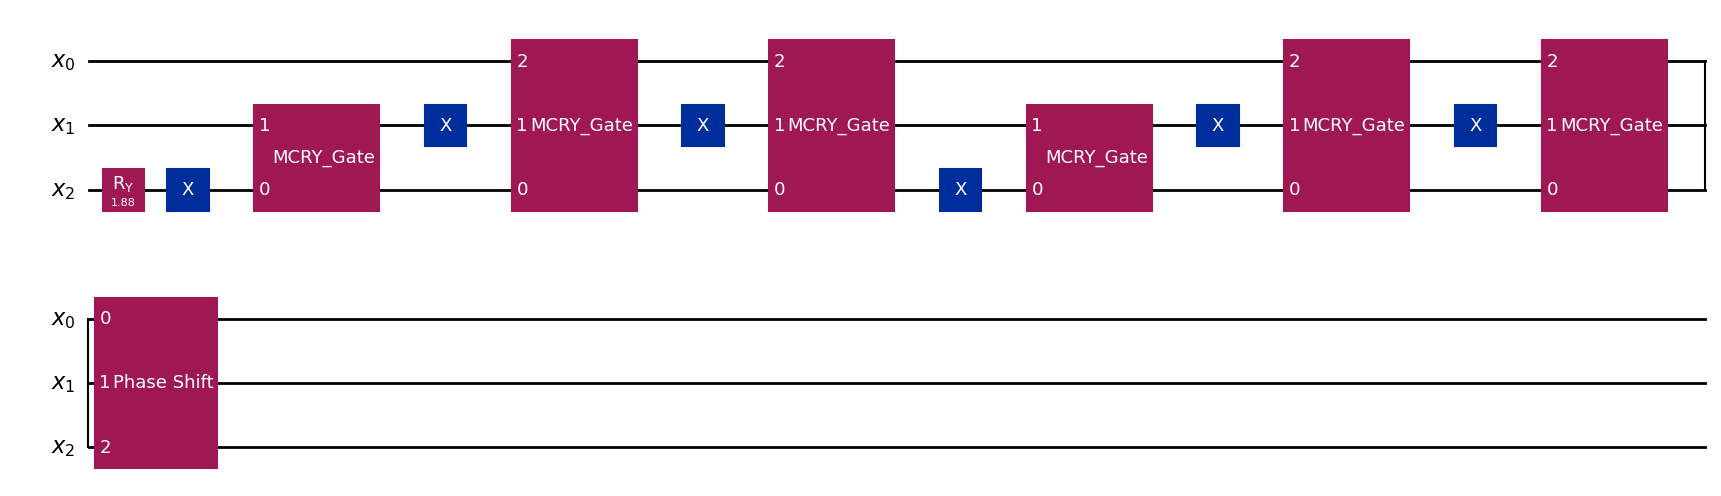

In [1219]:
testing(3)